In [54]:
import cv2
import os
import sklearn
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow as tf
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from tensorflow.keras.applications import Xception
from tensorflow.keras.callbacks import ReduceLROnPlateau, TensorBoard, ModelCheckpoint
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [55]:
# Base path and labels
base_path = './'
class_names = ['glioma_tumor', 'meningioma_tumor', 'no_tumor', 'pituitary_tumor']

# Constants
IMAGE_SIZE = 150
BATCH_SIZE = 16
VERBOSE = 1

###### Reading the dataset

In [56]:
import os
import cv2
import numpy as np
from tqdm import tqdm
from sklearn.utils import shuffle  

IMAGE_SIZE = 150  
x_train = []
y_train = []

class_names = ["glioma", "meningioma", "pituitary", "notumor"]
base_path = r"C:\Users\KIIT\Documents\training"

# 🔹 Load Training Data
for i in class_names:
    folderPath = os.path.join(base_path, "Training", i)

    if not os.path.exists(folderPath):
        print(f"❌ Error: Folder not found - {folderPath}")
        continue

    for j in tqdm(os.listdir(folderPath), ncols=70):
        img_path = os.path.join(folderPath, j)

        if not img_path.lower().endswith((".jpg", ".jpeg", ".png", ".bmp")):
            print(f"⚠️ Skipping non-image file: {j}")
            continue  

        img = cv2.imread(img_path)

        if img is None:
            print(f"❌ Error: Could not read {img_path}")
            continue  

        img = cv2.resize(img, (IMAGE_SIZE, IMAGE_SIZE))
        x_train.append(img)
        y_train.append(i)

print("✅ Training dataset loading complete.")

# 🔹 Load Testing Data
for i in class_names:
    folderPath = os.path.join(base_path, "Testing", i)

    if not os.path.exists(folderPath):
        print(f"❌ Error: Folder not found - {folderPath}")
        continue

    for j in tqdm(os.listdir(folderPath), ncols=70):
        img_path = os.path.join(folderPath, j)

        if not img_path.lower().endswith((".jpg", ".jpeg", ".png", ".bmp")):
            print(f"⚠️ Skipping non-image file: {j}")
            continue  

        img = cv2.imread(img_path)

        if img is None:
            print(f"❌ Error: Could not read {img_path}")
            continue  

        img = cv2.resize(img, (IMAGE_SIZE, IMAGE_SIZE))
        x_train.append(img)
        y_train.append(i)

print("✅ Testing dataset loading complete.")

# Convert to NumPy arrays
x_train = np.array(x_train).reshape(-1, IMAGE_SIZE, IMAGE_SIZE, 3)
y_train = np.array(y_train)

# 🚀 Debugging Prints
print(f"Loaded {len(x_train)} images and {len(y_train)} labels.")
if len(x_train) > 0:
    print(f"First image shape: {x_train[0].shape}")

# ✅ Prevent shuffle on empty data
if len(x_train) == 0 or len(y_train) == 0:
    print("❌ Error: x_train or y_train is empty. Check dataset loading.")
else:
    x_train, y_train = shuffle(x_train, y_train, random_state=0)


100%|███████████████████████████| 1595/1595 [00:01<00:00, 1305.20it/s]


✅ Training dataset loading complete.


100%|█████████████████████████████| 405/405 [00:00<00:00, 1814.32it/s]


✅ Testing dataset loading complete.
Loaded 7023 images and 7023 labels.
First image shape: (150, 150, 3)


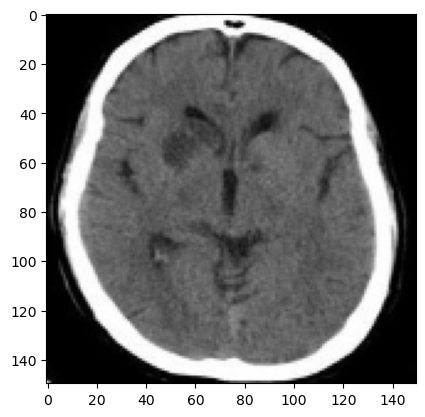

In [57]:
#example
plt.imshow(x_train[0])
plt.show()

In [58]:
x_train.shape,y_train.shape

((7023, 150, 150, 3), (7023,))

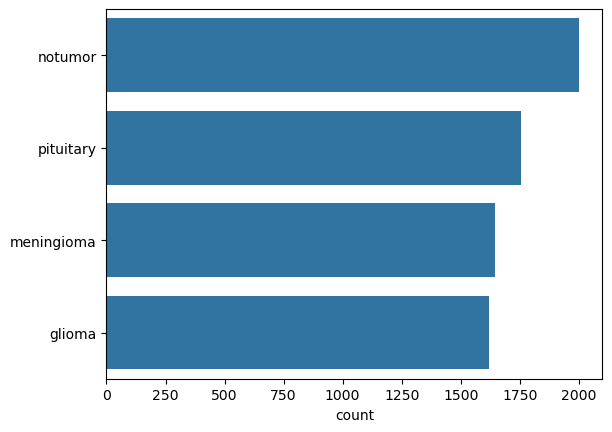

In [59]:
sns.countplot(y = y_train)
plt.show()

Sample of images in each class

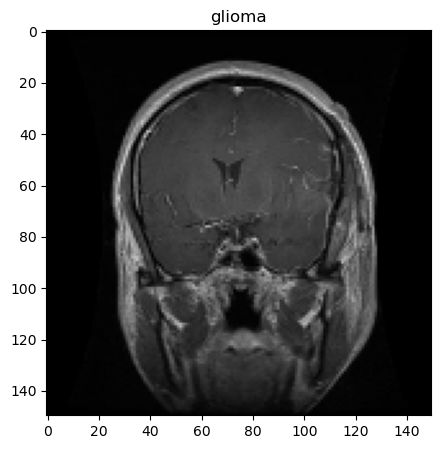

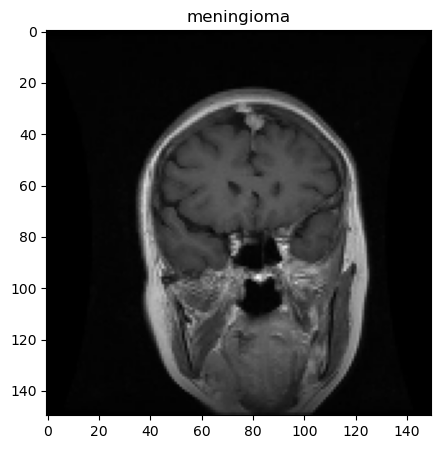

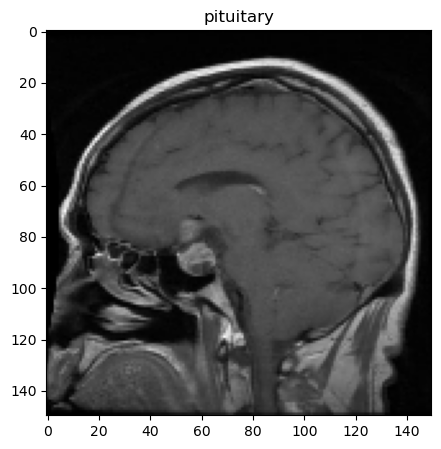

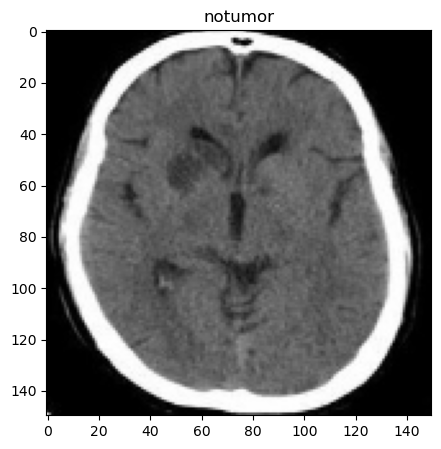

In [60]:
j=0
for i in class_names:
    j=0
    while True :
        if y_train[j]==i:
            plt.figure(figsize = (5,5))
            plt.imshow(x_train[j])
            plt.title(y_train[j])
            break
        j+=1

In [61]:
train_generator = ImageDataGenerator(rotation_range=10, zoom_range=0.10,
width_shift_range=0.10, height_shift_range=0.10, shear_range=0.10,
horizontal_flip=True, fill_mode="nearest")

In [62]:
# Split them into testing and training data
x_train, x_test, y_train, y_test = train_test_split(x_train, y_train, random_state=99, test_size=0.10)

print("Shapes X : Train :",x_train.shape,  " Test :",x_test.shape)
print("Shapes Y : Train :",y_train.shape,  " Test :",y_test.shape)

Shapes X : Train : (6320, 150, 150, 3)  Test : (703, 150, 150, 3)
Shapes Y : Train : (6320,)  Test : (703,)


Encoding the y_train and y_test to numbers

In [63]:
#for train data
y_train_new = [class_names.index(i) for i in y_train]
y_train = y_train_new
y_train = tf.keras.utils.to_categorical(y_train)

#for test data
y_test_new = [class_names.index(i) for i in y_test]
y_test = y_test_new
y_test = tf.keras.utils.to_categorical(y_test)

In [64]:
# Using the Xception Model
inputShape = (IMAGE_SIZE, IMAGE_SIZE, 3)
xception = Xception(weights="imagenet", input_shape=inputShape, include_top=False)

83683744/83683744 ━━━━━━━━━━━━━━━━━━━━ 5s 0us/step


In [65]:
# Adding the layers of Neural Network
model = xception.output
model = tf.keras.layers.GlobalAveragePooling2D()(model)
model = tf.keras.layers.Dropout(0.5)(model)
model = tf.keras.layers.Dense(4, activation='softmax')(model)
model = tf.keras.models.Model(inputs=xception.input, outputs=model)

Model summary

In [66]:
# Model summary
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 150, 150,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_conv1        │ (None, 74, 74,    │        864 │ input_layer[0][0] │
│ (Conv2D)            │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_conv1_bn     │ (None, 74, 74,    │        128 │ block1_conv1[0][… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_conv1_act    │ (None, 74, 74,    │          0 │ block1_conv1_bn[… │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_conv2        │ (None, 72, 72,    │     18,432 │ block1_conv1_act… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_conv2_bn     │ (None, 72, 72,    │        256 │ block1_conv2[0][… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_conv2_act    │ (None, 72, 72,    │          0 │ block1_conv2_bn[… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_sepconv1     │ (None, 72, 72,    │      8,768 │ block1_conv2_act… │
│ (SeparableConv2D)   │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_sepconv1_bn  │ (None, 72, 72,    │        512 │ block2_sepconv1[… │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_sepconv2_act │ (None, 72, 72,    │          0 │ block2_sepconv1_… │
│ (Activation)        │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_sepconv2     │ (None, 72, 72,    │     17,536 │ block2_sepconv2_… │
│ (SeparableConv2D)   │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_sepconv2_bn  │ (None, 72, 72,    │        512 │ block2_sepconv2[… │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 36, 36,    │      8,192 │ block1_conv2_act… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_pool         │ (None, 36, 36,    │          0 │ block2_sepconv2_… │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 36, 36,    │        512 │ conv2d[0][0]      │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 36, 36,    │          0 │ block2_pool[0][0… │
│                     │ 128)              │            │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block3_sepconv1_act │ (None, 36, 36,    │          0 │ add[0][0]       

 Total params: 20,869,676 (79.61 MB)

 Trainable params: 20,815,148 (79.40 MB)

 Non-trainable params: 54,528 (213.00 KB)

In [67]:
# Creating callbacks
tensorboard = TensorBoard(log_dir = 'logs')
checkpoint = ModelCheckpoint("brainTumor.keras",monitor="val_accuracy",save_best_only=True,mode="auto",verbose=VERBOSE, save_weights_only=False)
reduce_lr = ReduceLROnPlateau(monitor = 'val_accuracy', factor = 0.2, patience = 2, min_delta = 0.001,mode='max',verbose=VERBOSE)

In [68]:
# Generating customised dataset
train_dataset = tf.data.Dataset.from_generator(
    lambda: train_generator.flow(x_train, y_train, batch_size=BATCH_SIZE),
    output_signature=(
        tf.TensorSpec(shape=(None, *x_train.shape[1:]), dtype=tf.float32),
        tf.TensorSpec(shape=(None, *y_train.shape[1:]), dtype=tf.float32)
    )
)
train_dataset = train_dataset.repeat()

Training the model

In [69]:
# Compling and fitting the model
model.compile(loss='categorical_crossentropy', optimizer='Adam', metrics=['accuracy'])
history = model.fit(train_dataset, validation_data=(x_test, y_test), steps_per_epoch=len(x_train) // BATCH_SIZE,
                    epochs=12, callbacks=[reduce_lr, checkpoint, tensorboard]) 

Epoch 1/12
395/395 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.8176 - loss: 0.5549
Epoch 1: val_accuracy improved from -inf to 0.83642, saving model to brainTumor.keras
395/395 ━━━━━━━━━━━━━━━━━━━━ 742s 2s/step - accuracy: 0.8177 - loss: 0.5545 - val_accuracy: 0.8364 - val_loss: 0.5350 - learning_rate: 0.0010
Epoch 2/12
395/395 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9289 - loss: 0.2174
Epoch 2: val_accuracy improved from 0.83642 to 0.91607, saving model to brainTumor.keras
395/395 ━━━━━━━━━━━━━━━━━━━━ 847s 2s/step - accuracy: 0.9289 - loss: 0.2174 - val_accuracy: 0.9161 - val_loss: 0.2448 - learning_rate: 0.0010
Epoch 3/12
395/395 ━━━━━━━━━━━━━━━━━━━━ 0s 10s/step - accuracy: 0.9546 - loss: 0.1487 
Epoch 3: val_accuracy improved from 0.91607 to 0.92319, saving model to brainTumor.keras
395/395 ━━━━━━━━━━━━━━━━━━━━ 4089s 10s/step - accuracy: 0.9545 - loss: 0.1488 - val_accuracy: 0.9232 - val_loss: 0.2370 - learning_rate: 0.0010
Epoch 4/12
395/395 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step 

Training, loss vs epoch.

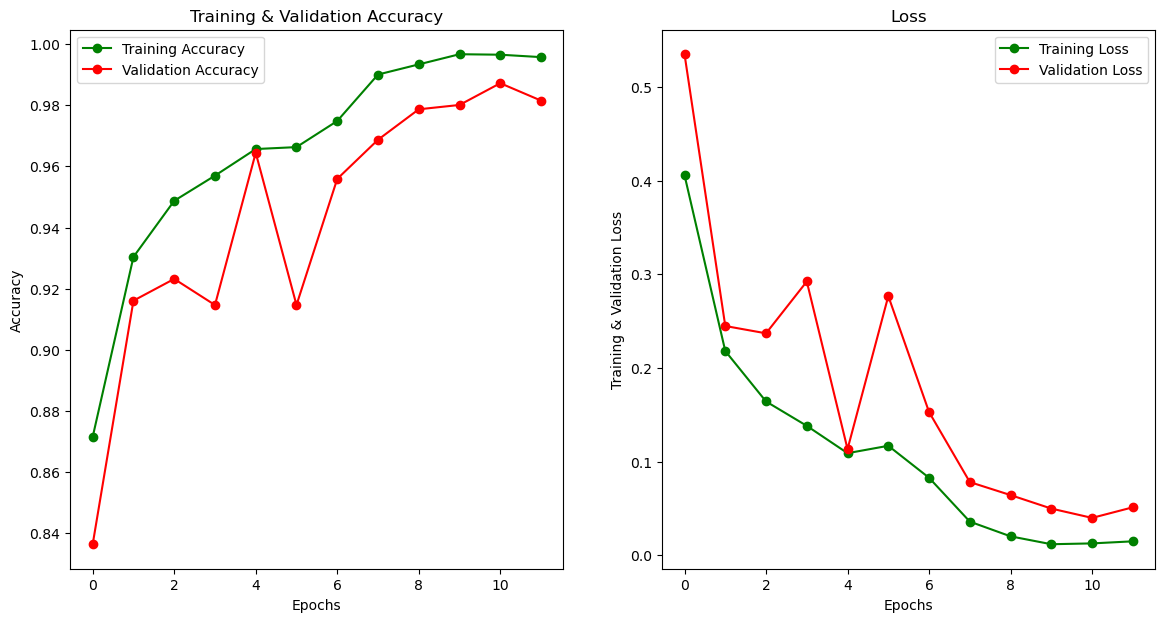

In [70]:
epochs = [i for i in range(12)]
fig, ax = plt.subplots(1,2)
train_acc = history.history['accuracy']
train_loss = history.history['loss']
val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']
fig.set_size_inches(14, 7)

ax[0].plot(epochs, train_acc, 'go-', label = 'Training Accuracy')
ax[0].plot(epochs, val_acc, 'ro-', label = 'Validation Accuracy')
ax[0].set_title('Training & Validation Accuracy')
ax[0].legend()
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Accuracy')

ax[1].plot(epochs, train_loss, 'g-o', label ='Training Loss')
ax[1].plot(epochs, val_loss, 'r-o', label = 'Validation Loss')
ax[1].set_title('Loss')
ax[1].legend()
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Training & Validation Loss')
plt.show()

Model performance

In [71]:
# Evaluating Model
result = model.evaluate(x_test, y_test)
print("Testing Loss :", result[0])
print("Testing Accuracy :", result[1]*100, "%")

22/22 ━━━━━━━━━━━━━━━━━━━━ 19s 848ms/step - accuracy: 0.9808 - loss: 0.0417
Testing Loss : 0.051272202283144
Testing Accuracy : 98.15078377723694 %


In [72]:
predictions = model.predict(x_test)
predictions = np.argmax(predictions, axis = 1)
y_test_edit = np.argmax(y_test , axis = 1)

22/22 ━━━━━━━━━━━━━━━━━━━━ 23s 910ms/step


Classification Report

In [73]:
cf_report = sklearn.metrics.classification_report(y_test_edit, predictions)
print(cf_report)

              precision    recall  f1-score   support

           0       0.99      0.99      0.99       146
           1       0.99      0.94      0.97       176
           2       0.96      1.00      0.98       164
           3       0.98      1.00      0.99       217

    accuracy                           0.98       703
   macro avg       0.98      0.98      0.98       703
weighted avg       0.98      0.98      0.98       703



Confusion Matrix

<Axes: >

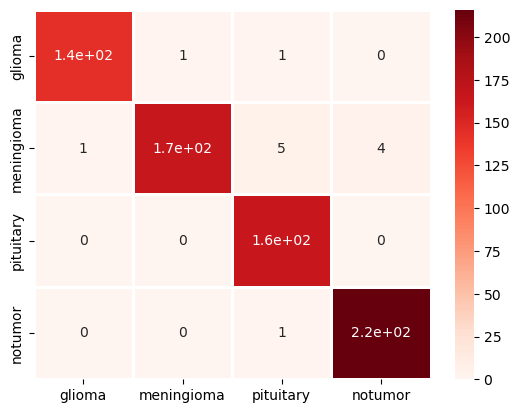

In [74]:
cf_matrix = sklearn.metrics.confusion_matrix(y_test_edit, predictions)
sns.heatmap(cf_matrix, cmap = 'Reds', linewidth = 1, annot = True, xticklabels=class_names, yticklabels=class_names)